<a href="https://colab.research.google.com/github/htnphu/retail-demand-forecasting/blob/main/m5_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8')

import gc

import logging
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Fall_2025/CPSC_5305_Intro_to_DS/data/"

In [ ]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype

        # --- FIX: Skip Datetime Columns ---
        if pd.api.types.is_datetime64_any_dtype(col_type):
            continue
        # -----------------------------------

        # Only process numeric columns for min/max
        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                # This is where the error occurred previously for datetime types
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # Handle categorical columns without min/max
        elif isinstance(col_type, pd.CategoricalDtype):
            df[col] = df[col].cat.as_unordered()  # Ensure no ordering assumption
        else:
            df[col] = df[col].astype('category')  # Convert objects to category
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased from {start_mem:.2f} Mb to {end_mem:.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [ ]:
print("Loading and reducing memory usage for data files...")

# load the datasets and apply memory reduction
calendar = pd.read_csv(f'{DATA_PATH}calendar.csv')
calendar = reduce_mem_usage(calendar)

sell_prices = pd.read_csv(f'{DATA_PATH}sell_prices.csv')
sell_prices = reduce_mem_usage(sell_prices)

# using 'sales_train_evaluation.csv' for the full data because it's the most complete one
sales = pd.read_csv(f'{DATA_PATH}sales_train_evaluation.csv')
sales = reduce_mem_usage(sales)

print("\nInitial data loading complete.")

Loading and reducing memory usage for data files...
Memory usage decreased from 0.21 Mb to 0.19 Mb (8.7% reduction)
Memory usage decreased from 208.77 Mb to 58.80 Mb (71.8% reduction)
Memory usage decreased from 452.91 Mb to 96.30 Mb (78.7% reduction)

Initial data loading complete.


## Calendar

In [ ]:
print(calendar.head().to_markdown())

|    | date       |   wm_yr_wk | weekday   |   wday |   month |   year | d   |   event_name_1 |   event_type_1 |   event_name_2 |   event_type_2 |   snap_CA |   snap_TX |   snap_WI |
|---:|:-----------|-----------:|:----------|-------:|--------:|-------:|:----|---------------:|---------------:|---------------:|---------------:|----------:|----------:|----------:|
|  0 | 2011-01-29 |      11101 | Saturday  |      1 |       1 |   2011 | d_1 |            nan |            nan |            nan |            nan |         0 |         0 |         0 |
|  1 | 2011-01-30 |      11101 | Sunday    |      2 |       1 |   2011 | d_2 |            nan |            nan |            nan |            nan |         0 |         0 |         0 |
|  2 | 2011-01-31 |      11101 | Monday    |      3 |       1 |   2011 | d_3 |            nan |            nan |            nan |            nan |         0 |         0 |         0 |
|  3 | 2011-02-01 |      11101 | Tuesday   |      4 |       2 |   2011 | d_4 |       

In [ ]:
calendar['date'] = pd.to_datetime(calendar['date'])

In [ ]:
print(calendar.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int16         
 2   weekday       1969 non-null   category      
 3   wday          1969 non-null   int8          
 4   month         1969 non-null   int8          
 5   year          1969 non-null   int16         
 6   d             1969 non-null   category      
 7   event_name_1  162 non-null    category      
 8   event_type_1  162 non-null    category      
 9   event_name_2  5 non-null      category      
 10  event_type_2  5 non-null      category      
 11  snap_CA       1969 non-null   int8          
 12  snap_TX       1969 non-null   int8          
 13  snap_WI       1969 non-null   int8          
dtypes: category(6), datetime64[ns](1), int16(2), int8(5)
memory usage: 128.3 KB
None


In [ ]:
print(calendar.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int16         
 2   weekday       1969 non-null   category      
 3   wday          1969 non-null   int8          
 4   month         1969 non-null   int8          
 5   year          1969 non-null   int16         
 6   d             1969 non-null   category      
 7   event_name_1  162 non-null    category      
 8   event_type_1  162 non-null    category      
 9   event_name_2  5 non-null      category      
 10  event_type_2  5 non-null      category      
 11  snap_CA       1969 non-null   int8          
 12  snap_TX       1969 non-null   int8          
 13  snap_WI       1969 non-null   int8          
dtypes: category(6), datetime64[ns](1), int16(2), int8(5)
memory usage: 128.3 KB
None


In [ ]:
print(calendar.shape)

(1969, 14)


In [ ]:
print(calendar.isnull().sum().to_markdown())

|              |    0 |
|:-------------|-----:|
| date         |    0 |
| wm_yr_wk     |    0 |
| weekday      |    0 |
| wday         |    0 |
| month        |    0 |
| year         |    0 |
| d            |    0 |
| event_name_1 | 1807 |
| event_type_1 | 1807 |
| event_name_2 | 1964 |
| event_type_2 | 1964 |
| snap_CA      |    0 |
| snap_TX      |    0 |
| snap_WI      |    0 |


In [ ]:
# Data Cleaning & Transformation for 'calendar'

# fill missing event values
event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

# convert to object, fill, then convert to category, this handles potential Categorical dtype errors and cleans the NaNs.
calendar[event_cols] = calendar[event_cols].astype('object')
calendar[event_cols] = calendar[event_cols].fillna('No event')
calendar[event_cols] = calendar[event_cols].astype('category')

calendar['date'] = pd.to_datetime(calendar['date'])

# Verify missing values (should be all 0 now)
print("Missing values in calendar after cleaning:")
print(calendar.isnull().sum().to_markdown())

# Data reduction: convert categorical columns to the category dtype
for col in calendar.columns:
    if calendar[col].dtype == 'object':
        calendar[col] = calendar[col].astype('category')

print("\nCalendar data cleaned and transformed.")

print(calendar.head().to_markdown())

Missing values in calendar after cleaning:
|              |   0 |
|:-------------|----:|
| date         |   0 |
| wm_yr_wk     |   0 |
| weekday      |   0 |
| wday         |   0 |
| month        |   0 |
| year         |   0 |
| d            |   0 |
| event_name_1 |   0 |
| event_type_1 |   0 |
| event_name_2 |   0 |
| event_type_2 |   0 |
| snap_CA      |   0 |
| snap_TX      |   0 |
| snap_WI      |   0 |

Calendar data cleaned and transformed.
|    | date                |   wm_yr_wk | weekday   |   wday |   month |   year | d   | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   snap_CA |   snap_TX |   snap_WI |
|---:|:--------------------|-----------:|:----------|-------:|--------:|-------:|:----|:---------------|:---------------|:---------------|:---------------|----------:|----------:|----------:|
|  0 | 2011-01-29 00:00:00 |      11101 | Saturday  |      1 |       1 |   2011 | d_1 | No event       | No event       | No event       | No event       |         0

In [ ]:
# calendar features
calendar['month'] = calendar['date'].dt.month
calendar['quarter'] = calendar['date'].dt.quarter
calendar['week'] = calendar['date'].dt.isocalendar().week
calendar['day_of_week'] = calendar['date'].dt.dayofweek
calendar['day_of_month'] = calendar['date'].dt.day
calendar['day_of_year'] = calendar['date'].dt.dayofyear
calendar['weekend'] = calendar['day_of_week'].isin([5, 6]).astype(int)
print(f"Calendar shape: {calendar.shape}")
calendar.head()

Calendar shape: (1969, 20)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,quarter,week,day_of_week,day_of_month,day_of_year,weekend
0,2011-01-29,11101,Saturday,1,1,2011,d_1,No event,No event,No event,No event,0,0,0,1,4,5,29,29,1
1,2011-01-30,11101,Sunday,2,1,2011,d_2,No event,No event,No event,No event,0,0,0,1,4,6,30,30,1
2,2011-01-31,11101,Monday,3,1,2011,d_3,No event,No event,No event,No event,0,0,0,1,5,0,31,31,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,No event,No event,No event,No event,1,1,0,1,5,1,1,32,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,No event,No event,No event,No event,1,0,1,1,5,2,2,33,0


## Sales - sales_train_evaluation.csv

In [ ]:
print(sales.head().to_markdown())

|    | id                            | item_id       | dept_id   | cat_id   | store_id   | state_id   |   d_1 |   d_2 |   d_3 |   d_4 |   d_5 |   d_6 |   d_7 |   d_8 |   d_9 |   d_10 |   d_11 |   d_12 |   d_13 |   d_14 |   d_15 |   d_16 |   d_17 |   d_18 |   d_19 |   d_20 |   d_21 |   d_22 |   d_23 |   d_24 |   d_25 |   d_26 |   d_27 |   d_28 |   d_29 |   d_30 |   d_31 |   d_32 |   d_33 |   d_34 |   d_35 |   d_36 |   d_37 |   d_38 |   d_39 |   d_40 |   d_41 |   d_42 |   d_43 |   d_44 |   d_45 |   d_46 |   d_47 |   d_48 |   d_49 |   d_50 |   d_51 |   d_52 |   d_53 |   d_54 |   d_55 |   d_56 |   d_57 |   d_58 |   d_59 |   d_60 |   d_61 |   d_62 |   d_63 |   d_64 |   d_65 |   d_66 |   d_67 |   d_68 |   d_69 |   d_70 |   d_71 |   d_72 |   d_73 |   d_74 |   d_75 |   d_76 |   d_77 |   d_78 |   d_79 |   d_80 |   d_81 |   d_82 |   d_83 |   d_84 |   d_85 |   d_86 |   d_87 |   d_88 |   d_89 |   d_90 |   d_91 |   d_92 |   d_93 |   d_94 |   d_95 |   d_96 |   d_97 |   d_98 |   d_99 |   d_100 |   d_

In [ ]:
print(sales.isnull().sum())

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1937      0
d_1938      0
d_1939      0
d_1940      0
d_1941      0
Length: 1947, dtype: int64


In [ ]:
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: category(6), int16(1317), int8(624)
memory usage: 96.3 MB
None


In [ ]:
print(sales.shape)

(30490, 1947)


In [ ]:
# show only columns with missing (NaN) values
sales.isnull().sum()[sales.isnull().sum() > 0]

,0


In [ ]:
# Data transformation for 'sales' (Melting to Long Format)

# identify the columns to keep as identifiers
id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

# identify the sale columns (d_1 to d_1941)
sales_cols = [col for col in sales.columns if col.startswith('d_')]

print("Melting sales data...")

# melt the df
sales_melted = sales.melt(
    id_vars=id_vars,
    value_vars=sales_cols,
    var_name='d',  # new column for the day ID (d_1, d_2, etc.)
    value_name='sales' # new column for the actual sales volume
)

sales_melted = reduce_mem_usage(sales_melted)


print("Sales data melted and memory reclaimed.")
print(f"Melted sales shape: {sales_melted.shape}")

Melting sales data...
Memory usage decreased from 1017.24 Mb to 678.68 Mb (33.3% reduction)
Sales data melted and memory reclaimed.
Melted sales shape: (59181090, 8)


In [ ]:
print(sales_melted.head().to_markdown())

|    | id                            | item_id       | dept_id   | cat_id   | store_id   | state_id   | d   |   sales |
|---:|:------------------------------|:--------------|:----------|:---------|:-----------|:-----------|:----|--------:|
|  0 | HOBBIES_1_001_CA_1_evaluation | HOBBIES_1_001 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 |
|  1 | HOBBIES_1_002_CA_1_evaluation | HOBBIES_1_002 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 |
|  2 | HOBBIES_1_003_CA_1_evaluation | HOBBIES_1_003 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 |
|  3 | HOBBIES_1_004_CA_1_evaluation | HOBBIES_1_004 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 |
|  4 | HOBBIES_1_005_CA_1_evaluation | HOBBIES_1_005 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 |


In [ ]:
print(sales_melted.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 8 columns):
 #   Column    Dtype   
---  ------    -----   
 0   id        category
 1   item_id   category
 2   dept_id   category
 3   cat_id    category
 4   store_id  category
 5   state_id  category
 6   d         category
 7   sales     int16   
dtypes: category(7), int16(1)
memory usage: 678.7 MB
None


In [ ]:
print(sales_melted['sales'].describe())

count    5.918109e+07
mean     1.130888e+00
std      3.870038e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      7.630000e+02
Name: sales, dtype: float64


In [ ]:
print(sales_melted.isnull().sum().to_markdown())

|          |   0 |
|:---------|----:|
| id       |   0 |
| item_id  |   0 |
| dept_id  |   0 |
| cat_id   |   0 |
| store_id |   0 |
| state_id |   0 |
| d        |   0 |
| sales    |   0 |


## Sell prices

In [ ]:
print(sell_prices.head().to_markdown())

|    | store_id   | item_id       |   wm_yr_wk |   sell_price |
|---:|:-----------|:--------------|-----------:|-------------:|
|  0 | CA_1       | HOBBIES_1_001 |      11325 |         9.58 |
|  1 | CA_1       | HOBBIES_1_001 |      11326 |         9.58 |
|  2 | CA_1       | HOBBIES_1_001 |      11327 |         8.26 |
|  3 | CA_1       | HOBBIES_1_001 |      11328 |         8.26 |
|  4 | CA_1       | HOBBIES_1_001 |      11329 |         8.26 |


In [ ]:
print(sell_prices.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype   
---  ------      -----   
 0   store_id    category
 1   item_id     category
 2   wm_yr_wk    int16   
 3   sell_price  float32 
dtypes: category(2), float32(1), int16(1)
memory usage: 58.8 MB
None


In [ ]:
print(sell_prices.shape)

(6841121, 4)


In [ ]:
print(sell_prices.isnull().sum().to_markdown())

|            |   0 |
|:-----------|----:|
| store_id   |   0 |
| item_id    |   0 |
| wm_yr_wk   |   0 |
| sell_price |   0 |


In [ ]:
print(sell_prices['sell_price'].describe())

count    6.841121e+06
mean     4.410955e+00
std      3.390167e+00
min      1.000000e-02
25%      2.180000e+00
50%      3.470000e+00
75%      5.840000e+00
max      1.073200e+02
Name: sell_price, dtype: float64


## Visualizing

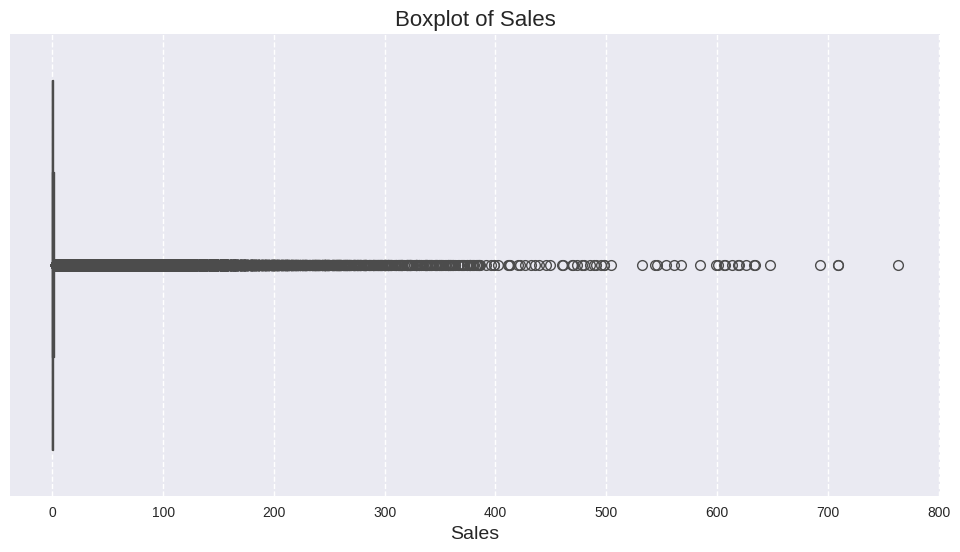

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=sales_melted['sales'], orient='h')
plt.title('Boxplot of Sales', fontsize=16)
plt.xlabel('Sales', fontsize=14)
plt.grid(axis='x', linestyle='--')

plt.show()

Merge sales_melted with calendar

In [ ]:
merge_sales_melter_calendar = sales_melted.merge(
    calendar[['d', 'date', 'event_name_1']],
    on='d',
    how='left'
)

In [ ]:
merge_sales_melter_calendar.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,event_name_1
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,No event
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,No event
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,No event
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,No event
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,No event


In [ ]:
merge_sales_melter_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 10 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             object        
 7   sales         int16         
 8   date          datetime64[ns]
 9   event_name_1  category      
dtypes: category(7), datetime64[ns](1), int16(1), object(1)
memory usage: 1.5+ GB


In [ ]:
total_sales_per_item = (
    merge_sales_melter_calendar
    .groupby('id', as_index=False)['sales']
    .sum()
    .rename(columns={'sales': 'total_sales'})
)

In [ ]:
total_sales_per_item

,id,total_sales
0,FOODS_1_001_CA_1_evaluation,1526
1,FOODS_1_001_CA_2_evaluation,2232
2,FOODS_1_001_CA_3_evaluation,2329
3,FOODS_1_001_CA_4_evaluation,694
4,FOODS_1_001_TX_1_evaluation,1145
...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,485
30486,HOUSEHOLD_2_516_TX_3_evaluation,243
30487,HOUSEHOLD_2_516_WI_1_evaluation,171
30488,HOUSEHOLD_2_516_WI_2_evaluation,64


In [ ]:
# not store specific
not_store_specific_total_sales_per_item = (
    sales_melted
    .groupby('item_id', as_index=False)['sales']
    .sum()
    .rename(columns={'sales': 'total_sales'})
)

not_store_specific_total_sales_per_item


,item_id,total_sales
0,FOODS_1_001,12404
1,FOODS_1_002,7465
2,FOODS_1_003,13578
3,FOODS_1_004,132251
4,FOODS_1_005,23419
...,...,...
3044,HOUSEHOLD_2_512,11707
3045,HOUSEHOLD_2_513,8012
3046,HOUSEHOLD_2_514,3199
3047,HOUSEHOLD_2_515,1153


In [ ]:
sorted_not_store_specific_total_sales_per_item = not_store_specific_total_sales_per_item.sort_values(
    by='total_sales', ascending=False
    )

In [ ]:
sorted_not_store_specific_total_sales_per_item.head()

,item_id,total_sales
702,FOODS_3_090,1017916
1198,FOODS_3_586,932236
864,FOODS_3_252,573723
1167,FOODS_3_555,497881
1199,FOODS_3_587,402159


In [ ]:
most_sold_date = (
    merge_sales_melter_calendar
    .groupby('date', as_index=False)['sales']
    .sum()
    .sort_values('sales', ascending=False)
)

most_sold_date.head(10)

,date,sales
1933,2016-05-15,59921
1863,2016-03-06,57218
1891,2016-04-03,56425
1897,2016-04-09,56340
1834,2016-02-06,55040
1708,2015-10-03,54687
1940,2016-05-22,54338
1932,2016-05-14,54308
1925,2016-05-07,54239
1616,2015-07-03,54154


In [ ]:
top_dates = most_sold_date.head(10)['date'].to_list()
top_sold_rows = calendar[calendar['date'].isin(top_dates)]
top_sold_rows

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,quarter,week,day_of_week,day_of_month,day_of_year,weekend
1616,2015-07-03,11522,Friday,7,7,2015,d_1617,No event,No event,No event,No event,1,1,1,3,27,4,3,184,0
1708,2015-10-03,11536,Saturday,1,10,2015,d_1709,No event,No event,No event,No event,1,1,1,4,40,5,3,276,1
1834,2016-02-06,11602,Saturday,1,2,2016,d_1835,No event,No event,No event,No event,1,1,1,1,5,5,6,37,1
1863,2016-03-06,11606,Sunday,2,3,2016,d_1864,No event,No event,No event,No event,1,1,1,1,9,6,6,66,1
1891,2016-04-03,11610,Sunday,2,4,2016,d_1892,No event,No event,No event,No event,1,1,1,2,13,6,3,94,1
1897,2016-04-09,11611,Saturday,1,4,2016,d_1898,No event,No event,No event,No event,1,1,1,2,14,5,9,100,1
1925,2016-05-07,11615,Saturday,1,5,2016,d_1926,No event,No event,No event,No event,1,1,0,2,18,5,7,128,1
1932,2016-05-14,11616,Saturday,1,5,2016,d_1933,No event,No event,No event,No event,0,0,1,2,19,5,14,135,1
1933,2016-05-15,11616,Sunday,2,5,2016,d_1934,No event,No event,No event,No event,0,1,1,2,19,6,15,136,1
1940,2016-05-22,11617,Sunday,2,5,2016,d_1941,No event,No event,No event,No event,0,0,0,2,20,6,22,143,1


In [ ]:
most_sold_date_with_calendar = (
    most_sold_date.merge(
        calendar[['date', 'weekday']],
        on='date',
        how='left'
    )
)

most_weekday_sales = (
    most_sold_date_with_calendar
    .groupby('weekday', as_index=False)['sales']
    .sum()
    .sort_values('sales', ascending=False)
)

most_weekday_sales.head()

,weekday,sales
2,Saturday,11594343
3,Sunday,11482526
0,Friday,9517020
1,Monday,9139596
5,Tuesday,8448634


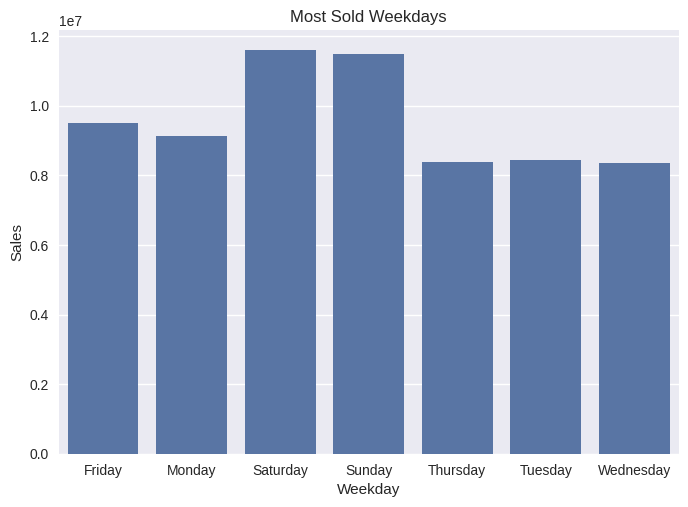

In [ ]:
sns.barplot(x='weekday', y='sales', data=most_weekday_sales)
plt.title('Most Sold Weekdays')
plt.xlabel('Weekday')
plt.ylabel('Sales')
plt.show()

In [ ]:
# event_sales = merge_sales_melter_calendar[
#     merge_sales_melter_calendar['event_name_1'] != 'No event']

# most_sold_event_date = event_sales.sort_values('sales', ascending=False).head()

# most_sold_event_date
event_sales = merge_sales_melter_calendar[
    merge_sales_melter_calendar['event_name_1'] != 'No event'
    # (merge_sales_melter_calendar['event_name_2'] != 'No event')
]

not_event_sales = merge_sales_melter_calendar[
    merge_sales_melter_calendar['event_name_1'] == 'No event'
]

# most_sold_event_date = (
#     event_sales
#     .groupby('date', as_index=False)['sales']
#     .sum()
#     .sort_values('sales', ascending=False)
# )

# most_sold_date.head()


In [ ]:
event_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,event_name_1
243920,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0,2011-02-06,SuperBowl
243921,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0,2011-02-06,SuperBowl
243922,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0,2011-02-06,SuperBowl
243923,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0,2011-02-06,SuperBowl
243924,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0,2011-02-06,SuperBowl


In [ ]:
'No event' in event_sales['event_name_1'].unique()

False

In [ ]:
print(len(event_sales))

4817420


In [ ]:
print(len(not_event_sales))

54363670


In [ ]:
most_sold_event_date = (
    event_sales
    .groupby('date', as_index=False)['sales']
    .sum()
    .sort_values('sales', ascending=False)
)

most_sold_event_date.head()

,date,sales
155,2016-05-01,53032
154,2016-04-30,50429
148,2016-02-14,48337
106,2014-10-04,47199
125,2015-04-12,47180


In [ ]:
most_sold_event_date.head()['date'].to_list()

[Timestamp('2016-05-01 00:00:00'),
 Timestamp('2016-04-30 00:00:00'),
 Timestamp('2016-02-14 00:00:00'),
 Timestamp('2014-10-04 00:00:00'),
 Timestamp('2015-04-12 00:00:00')]

In [ ]:
top_sold_event_dates = most_sold_event_date.head()['date'].to_list()
top_sold_event_rows = calendar[calendar['date'].isin(top_sold_event_dates)]
top_sold_event_rows

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,quarter,week,day_of_week,day_of_month,day_of_year,weekend
1344,2014-10-04,11436,Saturday,1,10,2014,d_1345,EidAlAdha,Religious,No event,No event,1,0,0,4,40,5,4,277,1
1534,2015-04-12,11511,Sunday,2,4,2015,d_1535,OrthodoxEaster,Religious,No event,No event,0,1,1,2,15,6,12,102,1
1842,2016-02-14,11603,Sunday,2,2,2016,d_1843,ValentinesDay,Cultural,No event,No event,0,0,1,1,6,6,14,45,1
1918,2016-04-30,11614,Saturday,1,4,2016,d_1919,Pesach End,Religious,No event,No event,0,0,0,2,17,5,30,121,1
1919,2016-05-01,11614,Sunday,2,5,2016,d_1920,OrthodoxEaster,Religious,No event,No event,1,1,0,2,17,6,1,122,1


In [ ]:
most_sold_event_date_with_calendar = (
    most_sold_event_date.merge(
        calendar[['date', 'weekday']],
        on='date',
        how='left'
    )
)

most_event_weekday_sales = (
    most_sold_event_date_with_calendar
    .groupby('weekday', as_index=False)['sales']
    .sum()
    .sort_values('sales', ascending=False)
)

most_event_weekday_sales.head()

,weekday,sales
3,Sunday,1484807
1,Monday,1220422
4,Thursday,782115
6,Wednesday,582974
2,Saturday,463200


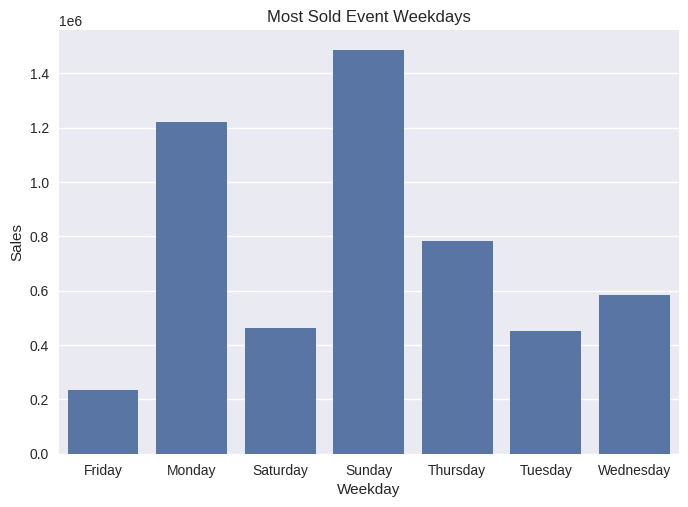

In [ ]:
sns.barplot(x='weekday', y='sales', data=most_event_weekday_sales)
plt.title('Most Sold Event Weekdays')
plt.xlabel('Weekday')
plt.ylabel('Sales')
plt.show()

In [ ]:
most_sold_not_event_date = (
    not_event_sales
    .groupby('date', as_index=False)['sales']
    .sum()
    .sort_values('sales', ascending=False)
)

most_sold_not_event_date.head()

,date,sales
1775,2016-05-15,59921
1712,2016-03-06,57218
1737,2016-04-03,56425
1743,2016-04-09,56340
1688,2016-02-06,55040


In [ ]:
most_sold_not_event_date_with_calendar = (
    most_sold_not_event_date.merge(
        calendar[['date', 'weekday']],
        on='date',
        how='left'
    )
)

most_not_event_weekday_sales = (
    most_sold_not_event_date_with_calendar
    .groupby('weekday', as_index=False)['sales']
    .sum()
    .sort_values('sales', ascending=False)
)

most_not_event_weekday_sales.head(7)

,weekday,sales
2,Saturday,11131143
3,Sunday,9997719
0,Friday,9281982
5,Tuesday,7998464
1,Monday,7919174
6,Wednesday,7763152
4,Thursday,7616813


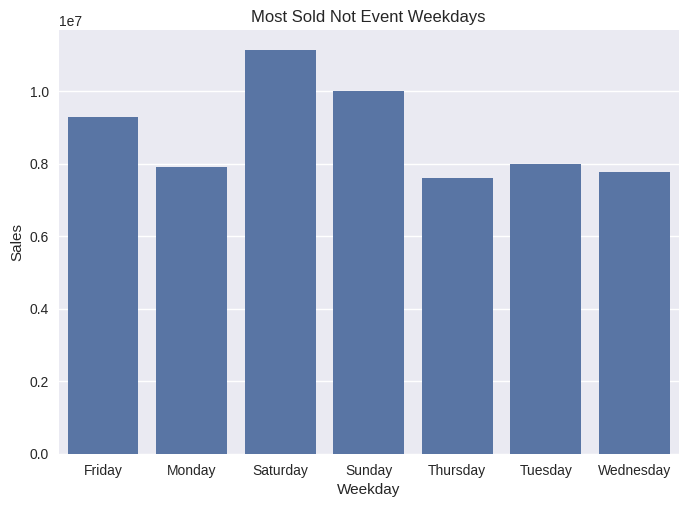

In [ ]:
sns.barplot(x='weekday', y='sales', data=most_not_event_weekday_sales)
plt.title('Most Sold Not Event Weekdays')
plt.xlabel('Weekday')
plt.ylabel('Sales')
plt.show()

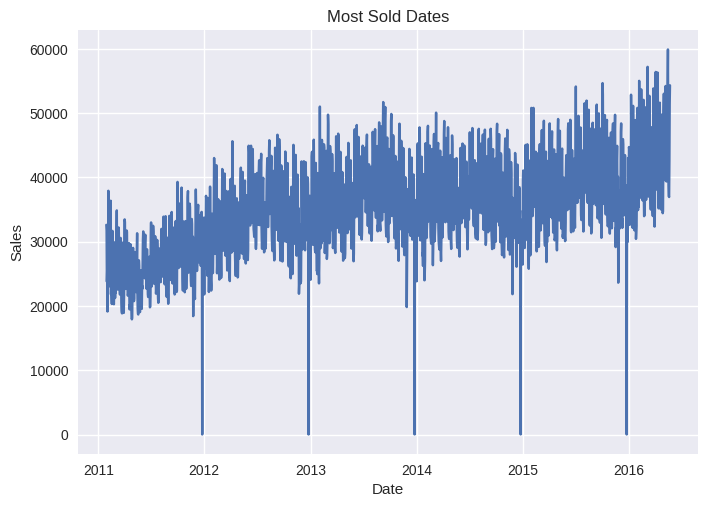

In [ ]:
sns.lineplot(x='date', y='sales', data=most_sold_date)
plt.title('Most Sold Dates')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

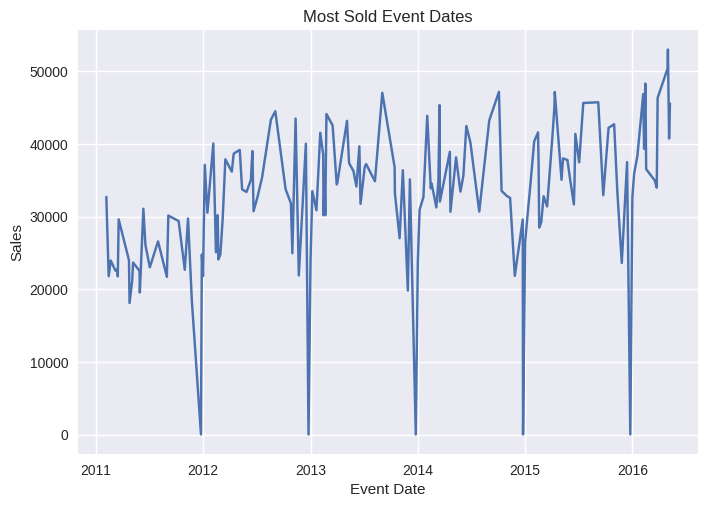

In [ ]:
sns.lineplot(x='date', y='sales', data=most_sold_event_date)
plt.title('Most Sold Event Dates')
plt.xlabel('Event Date')
plt.ylabel('Sales')
plt.show()

In [ ]:
# casual date but top most are weekend
most_sold_date['sales']


,sales
1933,59921
1863,57218
1891,56425
1897,56340
1834,55040
...,...
1061,20
1426,20
1791,14
330,13


In [ ]:
most_sold_event_date['sales']

,sales
155,53032
154,50429
148,48337
106,47199
125,47180
...,...
112,20
84,20
142,14
24,13


In [ ]:
print(calendar.head(1).to_markdown())

|    | date                |   wm_yr_wk | weekday   |   wday |   month |   year | d   | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   snap_CA |   snap_TX |   snap_WI |   quarter |   week |   day_of_week |   day_of_month |   day_of_year |   weekend |
|---:|:--------------------|-----------:|:----------|-------:|--------:|-------:|:----|:---------------|:---------------|:---------------|:---------------|----------:|----------:|----------:|----------:|-------:|--------------:|---------------:|--------------:|----------:|
|  0 | 2011-01-29 00:00:00 |      11101 | Saturday  |      1 |       1 |   2011 | d_1 | No event       | No event       | No event       | No event       |         0 |         0 |         0 |         1 |      4 |             5 |             29 |            29 |         1 |


In [ ]:
print(merge_sales_melter_calendar.head(1).to_markdown())

|    | id                            | item_id       | dept_id   | cat_id   | store_id   | state_id   | d   |   sales | date                | event_name_1   |
|---:|:------------------------------|:--------------|:----------|:---------|:-----------|:-----------|:----|--------:|:--------------------|:---------------|
|  0 | HOBBIES_1_001_CA_1_evaluation | HOBBIES_1_001 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 | 2011-01-29 00:00:00 | No event       |


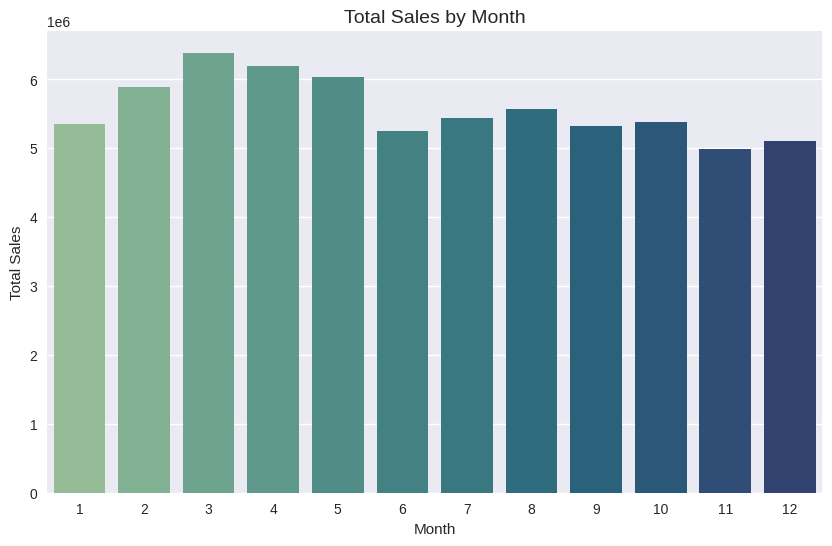

In [ ]:
full_features_merge_sales_melter_calendar = (
    merge_sales_melter_calendar.merge(
        calendar[['date', 'month', 'year', 'weekday', 'day_of_month']],
        on='date',
        how='left'
    )
)

monthly_sales = (
    full_features_merge_sales_melter_calendar
    .groupby('month', as_index=False)['sales']
    .sum()
    .sort_values('month')
)

plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_sales, x='month', y='sales', palette='crest')
plt.title("Total Sales by Month", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.show()

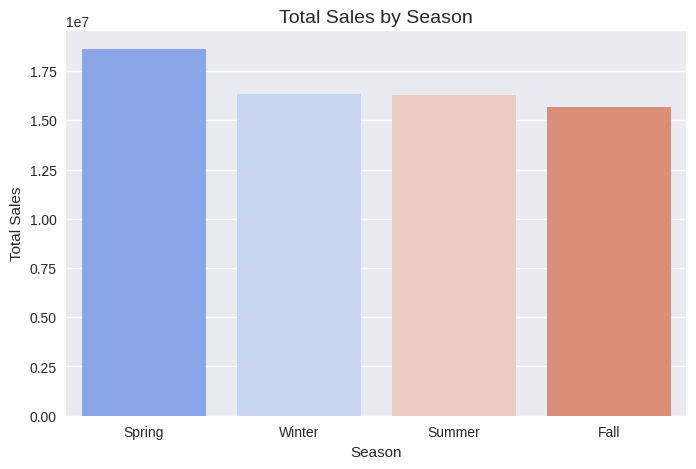

In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

full_features_merge_sales_melter_calendar['season'] = full_features_merge_sales_melter_calendar['month'].apply(get_season)

season_sales = (
    full_features_merge_sales_melter_calendar
    .groupby('season', as_index=False)['sales']
    .sum()
    .sort_values('sales', ascending=False)
)

plt.figure(figsize=(8, 5))
sns.barplot(data=season_sales, x='season', y='sales', palette='coolwarm')
plt.title("Total Sales by Season", fontsize=14)
plt.xlabel("Season")
plt.ylabel("Total Sales")
plt.show()

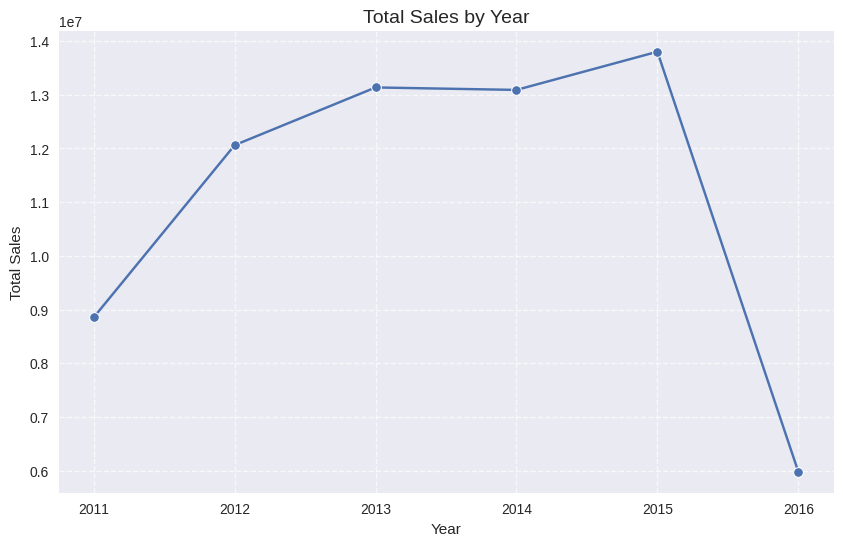

In [ ]:
yearly_sales = (
    full_features_merge_sales_melter_calendar
    .groupby('year', as_index=False)['sales']
    .sum()
)

plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_sales, x='year', y='sales', marker='o')
plt.title("Total Sales by Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


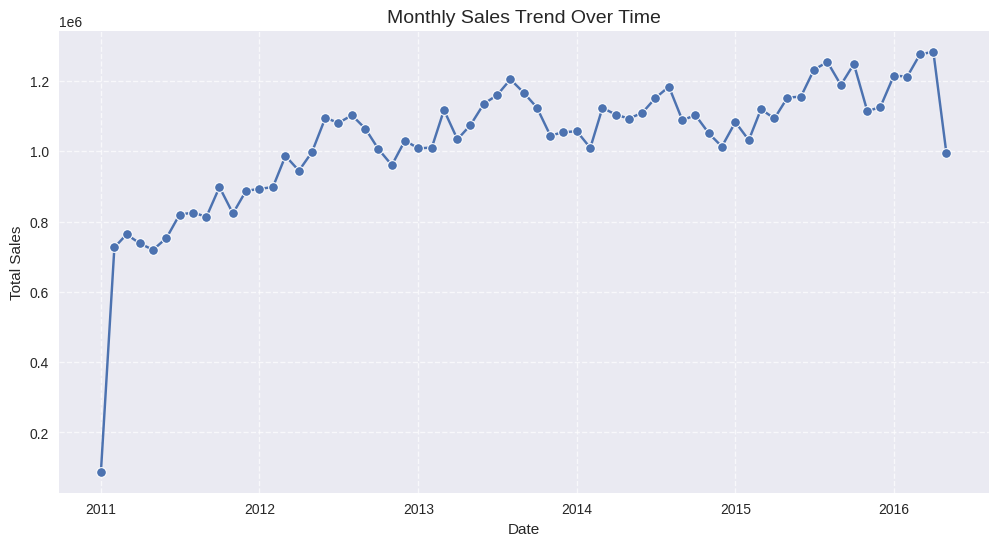

In [ ]:
monthly_trend = (
    full_features_merge_sales_melter_calendar
    .groupby(['year', 'month'], as_index=False)['sales']
    .sum()
)
monthly_trend['date'] = pd.to_datetime(monthly_trend[['year', 'month']].assign(day=1))

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trend, x='date', y='sales', marker='o')
plt.title("Monthly Sales Trend Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### BOXPLOT

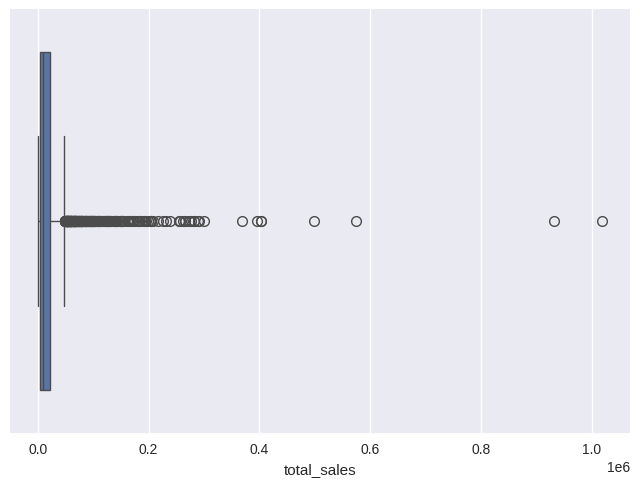

In [ ]:
sns.boxplot(x=not_store_specific_total_sales_per_item['total_sales'])

plt.show()

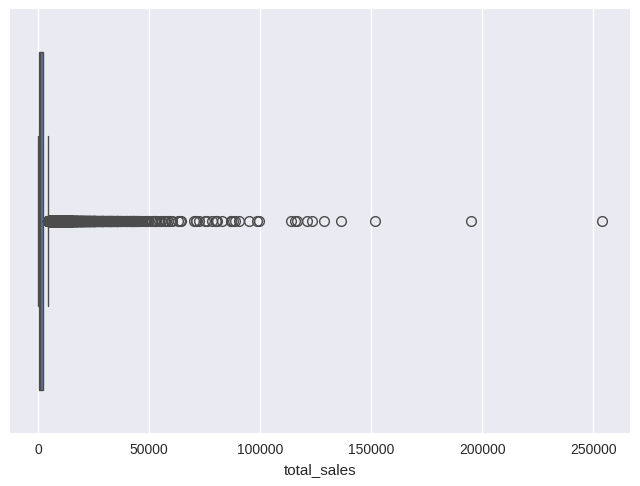

In [ ]:
sns.boxplot(x=total_sales_per_item['total_sales'])

plt.show()

In [ ]:
total_sales_per_item.head(10)

,id,total_sales
0,FOODS_1_001_CA_1_evaluation,1526
1,FOODS_1_001_CA_2_evaluation,2232
2,FOODS_1_001_CA_3_evaluation,2329
3,FOODS_1_001_CA_4_evaluation,694
4,FOODS_1_001_TX_1_evaluation,1145
5,FOODS_1_001_TX_2_evaluation,1120
6,FOODS_1_001_TX_3_evaluation,797
7,FOODS_1_001_WI_1_evaluation,1095
8,FOODS_1_001_WI_2_evaluation,897
9,FOODS_1_001_WI_3_evaluation,569


In [ ]:
total_sales_per_item.tail(10)

,id,total_sales
30480,HOUSEHOLD_2_516_CA_1_evaluation,321
30481,HOUSEHOLD_2_516_CA_2_evaluation,394
30482,HOUSEHOLD_2_516_CA_3_evaluation,286
30483,HOUSEHOLD_2_516_CA_4_evaluation,144
30484,HOUSEHOLD_2_516_TX_1_evaluation,232
30485,HOUSEHOLD_2_516_TX_2_evaluation,485
30486,HOUSEHOLD_2_516_TX_3_evaluation,243
30487,HOUSEHOLD_2_516_WI_1_evaluation,171
30488,HOUSEHOLD_2_516_WI_2_evaluation,64
30489,HOUSEHOLD_2_516_WI_3_evaluation,247


In [ ]:
# --- Merge with sell_prices ---
# First, you need to merge sell_prices based on 'store_id', 'item_id', and 'wm_yr_wk'
# For this step, we need the 'wm_yr_wk' column from the calendar data.
sales_with_cal_and_wm = sales_melted.merge(
    calendar[['d', 'wm_yr_wk']],
    on='d',
    how='left'
)

# Merge with sell_prices
final_df = sales_with_cal_and_wm.merge(
    sell_prices,
    on=['store_id', 'item_id', 'wm_yr_wk'],
    how='left'
)

# Merge calendar features again (since wm_yr_wk merge was intermediary)
final_df = final_df.merge(
    calendar[['d', 'date', 'weekday', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'day_of_week', 'day_of_month', 'day_of_year', 'weekend', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']],
    on='d',
    how='left',
    suffixes=('_sales', '_cal')
).drop(columns=['d_sales', 'weekday_sales']) # Clean up duplicated columns

# --- Calculate Correlation and Plot Heatmap ---
# Select numerical columns for correlation analysis
numeric_cols = [
    'sales', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI',
    'sell_price', 'day_of_week', 'day_of_month', 'day_of_year', 'weekend'
]

# Note: The full dataframe is ~1.5 GB. Correlation may be slow. A sample is often used for quick visualization.
# For a full capstone, you should use the full data for the most accurate correlation.
# Running the code below will take a long time on the entire dataset.

# Compute correlation matrix
correlation_matrix = final_df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    # fmt=\".2f\",
    cmap='coolwarm',
    cbar=True
)
plt.title('Correlation Matrix of Numerical Features')
plt.show()